In [1]:
# Basic imports, make sure they can import robustness
import torch as ch
from robustness.datasets import DATASETS
from robustness.tools.vis_tools import show_image_row
from robustness.tools import helpers
from robustness import model_utils, datasets
from torchvision.models import *
import torchvision.transforms as transforms
from robustness.tools.label_maps import CLASS_DICT

from tqdm import tqdm
import numpy as np
import PIL

%matplotlib inline

In [2]:
BATCH_SIZE = 5
NUM_WORKERS = 10

In [3]:
imagenet_ds = DATASETS['imagenet']('/scratch/engstrom_scratch/imagenet')
_, in_loader = imagenet_ds.make_loaders(NUM_WORKERS, BATCH_SIZE)
normalization_function = helpers.InputNormalize(imagenet_ds.mean, imagenet_ds.std)

==> Preparing dataset imagenet..


In [4]:
def load_model(arch, dataset=None):
    if arch != 'robust':
        model = eval(arch)(pretrained=True).cuda()
        model.eval()
        model = ch.nn.DataParallel(model)
        pass
    else:
        model_kwargs = {
            'arch': 'resnet50',
            'dataset': dataset,
            'resume_path': f'./models/RestrictedImageNet.pt'
        }

        model, _ = model_utils.make_and_restore_model(**model_kwargs)
        model.eval()
        model = model.module.model
    return model

model = load_model('resnet18')

In [5]:
def forward_pass(mod, im):
    im_norm = normalization_function(im)
    op = mod(im_norm.cuda())
    #if len(op) == 2:
    #    return op[0]
    #else:
    return op

In [6]:
if False: # Use only if dataloader is complete imagenet
    correct_cnt, total = 0, 0
    it = tqdm(enumerate(in_loader), total=len(in_loader))
    for itidx, (im, targ) in it:
        with ch.no_grad():
            op = forward_pass(model, im)
            pred = op.argmax(dim=1)
            correct = targ.cuda().eq(pred)

            correct_cnt += np.sum(correct.cpu().numpy())
            total += len(targ)
            it.set_description(f"Accuracy: {100 * correct_cnt/total:.2f}%")

In [19]:
def get_gradient(mod, im, targ, custom_loss=None):
    if custom_loss is None:
        loss_fn = ch.nn.CrossEntropyLoss()
    else:
        loss_fn = custom_loss 
        
    x = im.clone().detach().requires_grad_(True)
    op = forward_pass(mod, x)
    loss = loss_fn(op, targ.cuda())
    grad, = ch.autograd.grad(loss, [x])
    return grad.clone()

def vis_tensor(t):
    mt = ch.mean(t, dim=[2, 3], keepdim=True).expand_as(t)
    st = ch.std(t, dim=[2, 3], keepdim=True).expand_as(t)
    return ch.clamp((t - mt) / (2 * st) + 0.5, 0, 1) 

def smooth_grad(mod, im, targ, Nsamples, stdev, custom_loss=None):
    total_gradients = 0
    it = tqdm(enumerate(range(Nsamples)), total=Nsamples)
    for _, n in it:
        noise = ch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        grad = get_gradient(mod, noised_im, targ, custom_loss=custom_loss)
        total_gradients += grad

    return total_gradients / Nsamples

In [8]:
_, (img, targ) = next(enumerate(in_loader))

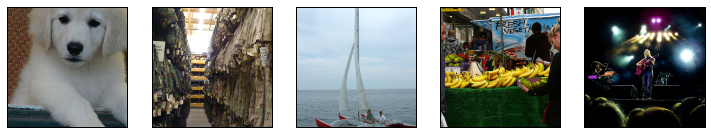

In [9]:
show_image_row([img[:10]])

In [10]:
grad = get_gradient(model, img, targ)
sgrad = smooth_grad(model, img, targ, 10, 0.3)

100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


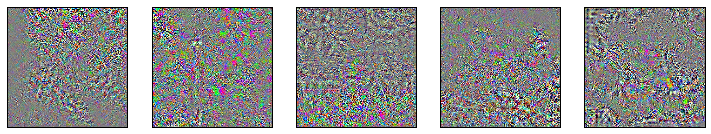

In [11]:
show_image_row([vis_tensor(grad)])

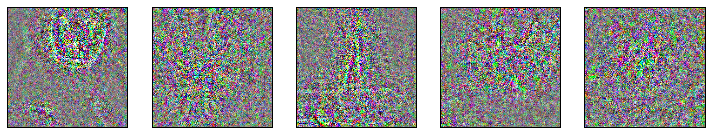

In [12]:
show_image_row([vis_tensor(sgrad)])

## Gradients of a robust model

In [13]:
restricted_imagenet_ds = datasets.RestrictedImageNet('/scratch/engstrom_scratch/imagenet')
_, rin_loader = restricted_imagenet_ds.make_loaders(workers=NUM_WORKERS, 
                                                          batch_size=BATCH_SIZE, 
                                                          data_aug=False)

CD = CLASS_DICT['RestrictedImageNet']

==> Preparing dataset restricted_imagenet..


In [14]:
robust_model = load_model('robust', restricted_imagenet_ds)

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


In [15]:
_, (img, targ) = next(enumerate(rin_loader))

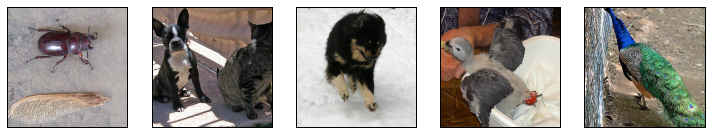

In [16]:
show_image_row([img])

In [17]:
grad_loss = get_gradient(robust_model, img, targ)

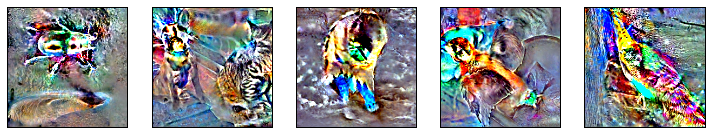

In [20]:
show_image_row([vis_tensor(grad_loss)])

In [22]:
def take_gradient_steps(mod, im, targ, step_size, Nsteps,
                        custom_loss=None, normalize=True, targeted=True):
    
    if custom_loss is None:
        loss_fn = ch.nn.CrossEntropyLoss()
    else:
        loss_fn = custom_loss 
        
    sign = -1 if targeted else 1
        
    it = tqdm(enumerate(range(Nsteps)), total=Nsteps)
    x = im.detach()
    l = len(x.shape) - 1
    
    for _, i in it:    
        x = x.clone().detach().requires_grad_(True)
        op = forward_pass(mod, x)
        loss = loss_fn(op, targ.cuda())
        g, = ch.autograd.grad(sign * loss, [x])
        it.set_description(f'Loss: {loss.item()}')
        #print(g.shape)
        with ch.no_grad():
            if normalize:
                g_norm = ch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1]*l))
                scaled_g = g / (g_norm + 1e-10)
            else: 
                scaled_g = g / 1
            
            x = ch.clamp(x + scaled_g * step_size, 0, 1)
    return x

In [29]:
targ_class = 5 * ch.ones_like(targ)
im_new = take_gradient_steps(robust_model, img, targ_class, 5, 20, 
                             custom_loss=None, normalize=True)

Loss: 0.0: 100%|██████████| 20/20 [00:01<00:00, 16.09it/s]                   


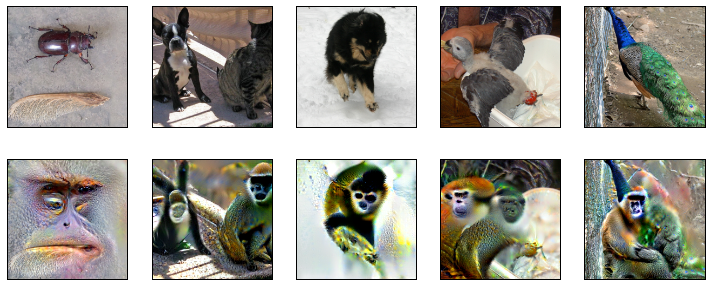

In [30]:
show_image_row([img, im_new])